In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1
First, I just bring in the data from SPY and VIX. The data is from Feb 11 2007 to Feb 11 2022. It is weekly data that I pulled from Yahoo Finance. I remove the Open, High, Low, Close, and Volume columns, as our strtagey is working with Adj Close data.

In [2]:
dfspy = pd.read_csv('SPY.csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
dfspy = dfspy.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
dfspy = dfspy.rename(columns = {'Adj Close' : 'SPY Adj Close'})
dfspy.head()

,SPY Adj Close
Date,
2007-02-12,108.318275
2007-02-19,107.998672
2007-02-26,103.070694
2007-03-05,104.639046
2007-03-12,102.966667


In [3]:
dfvix = pd.read_csv('^VIX.csv',
                index_col=0,       # Tell Pandas that the first column should be used as an index
                parse_dates=[0]    # Tell Pandas to parse the column at index 0 as dates
                )
dfvix = dfvix.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume'])
dfvix = dfvix.rename(columns = {'Adj Close' : 'VIX Adj Close'})
dfvix.head()

,VIX Adj Close
Date,
2007-02-12,10.020000
2007-02-19,10.580000
2007-02-26,18.610001
2007-03-05,14.090000
2007-03-12,16.790001


### Step 2
I merge the dataframes of SPY and VIX data. I then split the data into a 70-30 split. 

In [4]:
df = dfspy.join(dfvix, on='Date')
dftrain = df[:(int(0.7*len(df)))]
dftest = df[(int(0.7*len(df))):]
dftrain.head()

,SPY Adj Close,VIX Adj Close
Date,,
2007-02-12,108.318275,10.020000
2007-02-19,107.998672,10.580000
2007-02-26,103.070694,18.610001
2007-03-05,104.639046,14.090000
2007-03-12,102.966667,16.790001


### Step 3
This is an oversimplified version of the strtaegy planned. I was going to change it to add in the stop-losses and the additional constraints to exiting positions. However, when I tested out a version of this strategy WITHOUT any condition for a short position, we seem to get some interesting results. 

In [5]:
def strategy(df_og):
    df = df_og.copy()
    df['12EMA'] = df['SPY Adj Close'].ewm(span = 12, adjust = False).mean()
    df['26EMA'] = df['SPY Adj Close'].ewm(span = 26, adjust = False).mean()
    df['MACD'] = df['12EMA'] - df['26EMA']
    df['Signal'] = df['MACD'].ewm(span = 9, adjust = False).mean()
    df['Position'] = np.where(((df['MACD'] > df['Signal']) &
                               ((df['MACD'] < 0) |
                                df['VIX Adj Close'] < df['VIX Adj Close'].quantile(0.25))),
                             1,0)
#     df['Position'] = np.where(((df['MACD'] < df['Signal']) &
#                                (df['MACD'] > 0)), -1 , 0)
    
    df['SPY returns'] = df['SPY Adj Close'].pct_change()
    df['P&L'] = df['Position']*df['SPY returns']
    return df

In [6]:
train = strategy(dftrain)
train.tail()

,SPY Adj Close,VIX Adj Close,12EMA,26EMA,MACD,Signal,Position,SPY returns,P&L
Date,,,,,,,,,
2017-07-10,226.823593,9.51,222.300652,217.590864,4.709787,4.816789,0,0.014249,0.000000
2017-07-17,228.042862,9.36,223.184069,218.365086,4.818982,4.817227,1,0.005375,0.005375
2017-07-24,228.070602,10.29,223.935843,219.084014,4.851830,4.824148,1,0.000122,0.000122
2017-07-31,228.532455,10.03,224.643014,219.783898,4.859116,4.831141,1,0.002025,0.002025
2017-08-07,225.493454,15.51,224.773851,220.206828,4.567023,4.778318,0,-0.013298,-0.000000


In [13]:
print("The average of SPY returns was", train['SPY returns'].rolling(26).mean().mean())
print("The average of our strategy P&L was", train['P&L'].rolling(26).mean().mean())

The average of SPY returns was 0.0016717361597334134
The average of our strategy P&L was 0.0021490008029238627


In [12]:
print("The average volatilty of SPY returns was", train['SPY returns'].rolling(26).std().mean())
print("The average volatilty of our strategy was", train['P&L'].rolling(26).std().mean())

The average volatilty of SPY returns was 0.022791708502451453
The average volatilty of our strategy was 0.012693169353859836


### Step 4
We have a better Sharpe ratio (unannualized) than the S&P 500. The graph shows that this is largely because we are resitant to recessions. 

In [15]:
print("training dataset Strategy sharpe ratio (unannualized):", train['P&L'].mean()/train['P&L'].std())
print("testing datatset SPY sharpe ratio (unannualized):", train['SPY returns'].mean()/train['SPY returns'].std())

training dataset Strategy sharpe ratio (unannualized): 0.1479653689335053
testing datatset SPY sharpe ratio (unannualized): 0.06539972063692864


<AxesSubplot:xlabel='Date'>

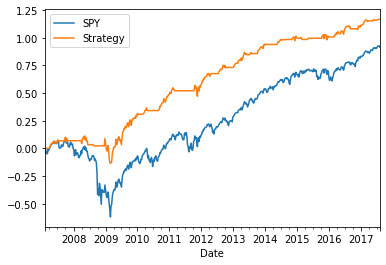

In [8]:
pnl = pd.DataFrame({'SPY':train['SPY returns'],
                   'Strategy':train['P&L']})
pnl.cumsum().plot()